**Flowsheet Containing a Single Heater**

**Problem Statement**: Consider the process of heating a Benzene-Toluene mixture with the following inlet specificatons:

Flow Rate = 1 kmol/hr

Mole fraction (Benzene) = 0.4

Mole fraction (Toluene) = 0.6

Pressure = 101325 Pa

Temperature = 353 K

![](heater_2.svg)

We will study the simulation of the heater as follows, by fixing the possible degrees of freedom (outlet temperature and heat duty) one at a time:

1. If it is required to heat this mixture such that an outlet temperature of 363 K is to be obtained, we would like to know the heat duty (J/s)
2. If it is required to supply heat to the mixture at a fixed rate: 2 J/s, we would like to know the outlet temperature (K) 

IDAES documentation reference for heater model: https://idaes-pse.readthedocs.io/en/stable/models/heater.html#

**Setting up the problem in IDAES**

In [1]:
# Import pyomo package 
from pyomo.environ import ConcreteModel, SolverFactory, Constraint, value

# Import the main FlowsheetBlock from IDAES. The flowsheet block will contain the unit model
from idaes.core import FlowsheetBlock

# Import idaes logger to set output levels
import idaes.logger as idaeslog

#Create the ConcreteModel and the FlowsheetBlock, and attach the flowsheet block to it.
m = ConcreteModel()
m.fs = FlowsheetBlock(default={"dynamic": False})
# dynamic or ss flowsheet needs to be specified here

#Import the BTX_ideal property package to create a properties block for the flowsheet
from idaes.generic_models.properties.activity_coeff_models import BTX_activity_coeff_VLE

# Add properties as parameters to flowsheet directly, and attach the properties block to the flowsheet
m.fs.properties = BTX_activity_coeff_VLE.BTXParameterBlock(default={"valid_phase":
                                                     'Liq',
                                                     "activity_coeff_model":
                                                     "Ideal"})

In [2]:
#Import a heater unit
from idaes.generic_models.unit_models.heater import Heater

#Create an instance of the heater unit, attaching it to the flowsheet
#Specify that the property package to be used with the heater is the one we created earlier.
m.fs.heater = Heater(default={"property_package": m.fs.properties})

#Import the degrees_of_freedom function from the idaes.core.util.model_statistics package
from idaes.core.util.model_statistics import degrees_of_freedom
# DOF = Number of Model Variables - Number of Model Constraints

# Call the degrees_of_freedom function, get intitial DOF
DOF_initial = degrees_of_freedom(m)
print("The initial DOF is {0}".format(DOF_initial))

#Fix the BT stream inlet conditions
m.fs.heater.inlet.flow_mol.fix(1*1000/3600)
m.fs.heater.inlet.mole_frac_comp[0, "benzene"].fix(0.4)
m.fs.heater.inlet.mole_frac_comp[0, "toluene"].fix(0.6)
m.fs.heater.inlet.pressure.fix(101325)
m.fs.heater.inlet.temperature.fix(353)

The initial DOF is 6


**Case 1: Fix Outlet Temperature**

In [3]:
m.fs.heater.outlet.temperature.fix(363)
# Call the degrees_of_freedom function, get final DOF
DOF_final = degrees_of_freedom(m)
print("The final DOF is {0}".format(DOF_final))

The final DOF is 0


**Flowsheet Initialization**

In [4]:
#IDAES includes pre-written initialization routines for all unit models.
#Initialize the flowsheet, and set the output at different levels
m.fs.heater.initialize(outlvl=idaeslog.WARNING)

#Note: The output level can be changed by the user as per requirement 

In [5]:
m.fs.heater.initialize(outlvl=idaeslog.INFO_HIGH)

2020-03-12 13:12:36 - INFO - idaes.init.fs.heater.control_volume.properties_in - Initialization Step 1 skipped.
2020-03-12 13:12:36 - INFO - idaes.init.fs.heater.control_volume.properties_in - Initialization Step 2 optimal - Optimal Solution Found.
2020-03-12 13:12:36 - INFO - idaes.init.fs.heater.control_volume.properties_in - Initialization Step 3 optimal - Optimal Solution Found.
2020-03-12 13:12:36 - INFO - idaes.init.fs.heater.control_volume.properties_in - Initialization Step 4 optimal - Optimal Solution Found.
2020-03-12 13:12:36 - INFO - idaes.init.fs.heater.control_volume.properties_in - Initialization Step 5 optimal - Optimal Solution Found.
2020-03-12 13:12:36 - INFO - idaes.init.fs.heater.control_volume.properties_out - Initialization Step 1 skipped.
2020-03-12 13:12:36 - INFO - idaes.init.fs.heater.control_volume.properties_out - Initialization Step 2 optimal - Optimal Solution Found.
2020-03-12 13:12:37 - INFO - idaes.init.fs.heater.control_volume.properties_out - Initial

**Obtaining Simulation Results**

In [6]:
#Solve the simulation using ipopt
#Note: If the degrees of freedom = 0, we have a square problem
opt = SolverFactory('ipopt')
opt.solve(m)

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 17, 'Number of variables': 17, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.12.13\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.03590846061706543}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

**View Results**

In [7]:
#Display Heat Duty only
m.fs.heater.heat_duty.display()

heat_duty : Size=1, Index=fs.time
    Key : Lower : Value              : Upper : Fixed : Stale : Domain
    0.0 :  None : 459.10147722222354 :  None : False : False :  Reals


In [8]:
#Display a readable report
m.fs.heater.report()


Unit : fs.heater                                                           Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key       : Value  : Fixed : Bounds
    Heat Duty : 459.10 : False : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                              Inlet     Outlet  
    flow_mol                  0.27778    0.27778
    mole_frac_comp benzene    0.40000    0.40000
    mole_frac_comp toluene    0.60000    0.60000
    temperature                353.00     363.00
    pressure               1.0132e+05 1.0132e+05


**Case 2: Fix Heat Duty**

In [9]:
#Fix heat duty and solve the model 
m.fs.heater.outlet.temperature.unfix()
m.fs.heater.heat_duty.fix(459.10147722222354)
opt.solve(m)

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 17, 'Number of variables': 17, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.12.13\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.047872304916381836}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [10]:
#Display outlet temperature only
m.fs.heater.outlet.temperature.display()

_outlet_temperature_ref : Size=1, Index=fs.time
    Key : Lower : Value : Upper : Fixed : Stale : Domain
    0.0 :     0 : 363.0 :  None : False : False : NonNegativeReals


In [11]:
#Display a readable report
m.fs.heater.report()


Unit : fs.heater                                                           Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key       : Value  : Fixed : Bounds
    Heat Duty : 459.10 :  True : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                              Inlet     Outlet  
    flow_mol                  0.27778    0.27778
    mole_frac_comp benzene    0.40000    0.40000
    mole_frac_comp toluene    0.60000    0.60000
    temperature                353.00     363.00
    pressure               1.0132e+05 1.0132e+05


**Sensitivity Plot**

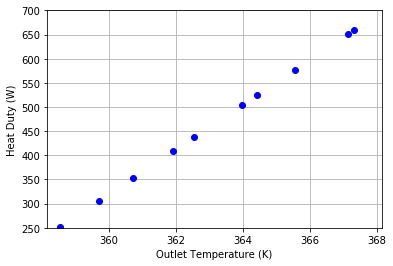

In [14]:
# Heat Duty vs Outlet Teamperature
import matplotlib.pyplot as plt
import numpy as np

#Unfix the heat duty from case 2
m.fs.heater.heat_duty.unfix()

#Create a list of outlet temperatures for which corresponding heat duty values need to be obtained
outlet_temp_fixed = [91.256405+273.15,
90.828456+273.15,
86.535145+273.15,
89.383218+273.15,
93.973657+273.15,
85.377274+273.15,
92.399101+273.15,
94.151562+273.15,
87.564579+273.15,
88.767855+273.15]

#Fix the outlet temperature values and solve the model to obtain the heat duties
heat_duty = []
for temp in outlet_temp_fixed:
    m.fs.heater.outlet.temperature.fix(temp)
    opt.solve(m)
    heat_duty.append(m.fs.heater.heat_duty[0].value) 
plt.xlim(358.15,368.15)
plt.ylim(250,700)
plt.plot(outlet_temp_fixed,heat_duty,'bo')
plt.xlabel('Outlet Temperature (K)')
plt.ylabel('Heat Duty (W)')
plt.grid()
plt.show()